# Overfit-generalization-underfit

No caderno anterior, apresentamos a estrutura geral de validação cruzada
e como isso nos ajuda a quantificar os erros de treinamento e teste também
como suas flutuações.

Neste caderno, colocaremos esses dois erros em perspectiva e mostraremos como
eles podem nos ajudar a saber se nosso modelo é generalizado, superajustado ou insuficiente.

Vamos primeiro carregar os dados e criar o mesmo modelo do anterior
caderno.

In [1]:
from sklearn.datasets import fetch_california_housing

housing = fetch_california_housing(as_frame=True)
data, target = housing.data, housing.target
target *= 100  # rescale the target in k$

<div class="admonition note alert alert-info">
<p class="first admonition-title" style="font-weight: bold;">Note</p>
<p class="last">Se você quiser uma visão geral mais aprofundada sobre este conjunto de dados, pode consultar o
Appendix - Datasets seção de descrição no final deste MOOC.</p>
</div>

In [2]:
from sklearn.tree import DecisionTreeRegressor

regressor = DecisionTreeRegressor()

## Overfitting vs. underfitting

Para entender melhor o desempenho estatístico do nosso modelo e talvez encontrar
insights sobre como melhorá-lo, vamos comparar o erro de teste com o
erro de treinamento. Assim, precisamos calcular o erro no conjunto de treinamento,
que é possível usando a função `cross_validate`.

In [3]:
import pandas as pd
from sklearn.model_selection import cross_validate, ShuffleSplit

cv = ShuffleSplit(n_splits=30, test_size=0.2)
cv_results = cross_validate(regressor, data, target,
                            cv=cv, scoring="neg_mean_absolute_error",
                            return_train_score=True, n_jobs=2)
cv_results = pd.DataFrame(cv_results)

A validação cruzada utilizou o erro absoluto médio negativo. Nós transformamos
o erro médio absoluto negativo em um erro absoluto médio positivo.

In [4]:
scores = pd.DataFrame()
scores[["train error", "test error"]] = -cv_results[
    ["train_score", "test_score"]]

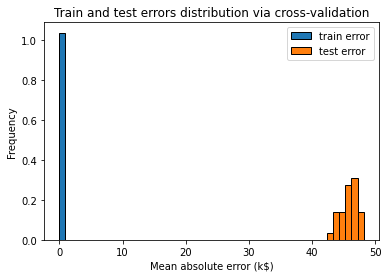

In [5]:
import matplotlib.pyplot as plt

scores.plot.hist(bins=50, edgecolor="black", density=True)
plt.xlabel("Mean absolute error (k$)")
_ = plt.title("Train and test errors distribution via cross-validation")

Traçando a distribuição dos erros de treinamento e teste, nós
obter informações sobre se o nosso modelo é sobreajustado, insuficiente (ou
Ambos ao mesmo tempo).

Aqui, observamos um **small training error** (na verdade, zero), o que significa que
o modelo **não é insuficiente**: é flexível o suficiente para capturar qualquer
variações presentes no conjunto de treinamento.

No entanto, o **not under-fitting** nos diz que o
modelo é **over-fitting**: o modelo memorizou muitas variações do
conjunto de treinamento que pode ser considerado "barulhento" porque não generaliza
para nos ajudar a fazer uma boa previsão no conjunto de teste.


## Validation curve

Alguns hiperparâmetros de modelo são geralmente a chave para ir de um modelo que
underfits para um modelo que overfits, esperançosamente passando por uma região onde
pode obter um bom equilíbrio entre os dois. Podemos adquirir conhecimento traçando
uma curva chamada curva de validação. Esta curva também pode ser aplicada ao
acima do experimento e varia o valor de um hiperparâmetro.

Para a árvore de decisão, o parâmetro `max_depth` é usado para controlar o
compensação entre ajuste insuficiente e ajuste excessivo. (under-fitting and over-fitting.)

In [6]:
%%time
from sklearn.model_selection import validation_curve

max_depth = [1, 5, 10, 15, 20, 25]
train_scores, test_scores = validation_curve(
    regressor, data, target, param_name="max_depth", param_range=max_depth,
    cv=cv, scoring="neg_mean_absolute_error", n_jobs=2)
train_errors, test_errors = -train_scores, -test_scores

Wall time: 14.6 s


Agora que coletamos os resultados, mostraremos a curva de validação por
traçar os erros de treinamento e teste (bem como seus desvios).

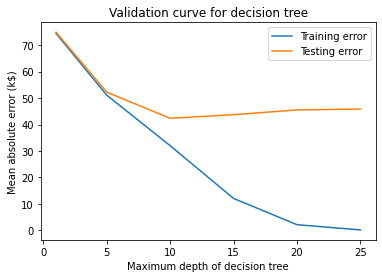

In [7]:
plt.plot(max_depth, train_errors.mean(axis=1), label="Training error")
plt.plot(max_depth, test_errors.mean(axis=1), label="Testing error")
plt.legend()

plt.xlabel("Maximum depth of decision tree")
plt.ylabel("Mean absolute error (k$)")
_ = plt.title("Validation curve for decision tree")

A curva de validação pode ser dividida em três áreas:

- Para `max_depth <10`, a árvore de decisão é inadequada. O erro de treinamento e
  portanto, os erros de teste são altos. O modelo é também
  restrito e não pode capturar muito da variabilidade do alvo
  variável.

- A região em torno de `max_depth = 10` corresponde ao parâmetro para o qual
  a árvore de decisão generaliza o melhor. É flexível o suficiente para capturar um
  fração da variabilidade do alvo que generaliza, embora não
  memorizar todo o ruído no alvo.

- Para `max_depth> 10`, a árvore de decisão superajustes. O erro de treinamento
  torna-se muito pequeno, enquanto o erro de teste aumenta. Nisso
  região, os modelos criam decisões especificamente para amostras ruidosas que prejudicam
  sua capacidade de generalizar para testar dados.

Observe que para `max_depth = 10`, o modelo superafe um pouco, pois há uma lacuna
entre o erro de treinamento e o erro de teste. Também pode
potencialmente insuficiente também um pouco ao mesmo tempo, porque o erro de treinamento
ainda está longe de zero (mais de 30 k\\$), o que significa que o modelo pode
ainda ser muito restrito para modelar partes interessantes dos dados. No entanto, o
o erro de teste é mínimo e isso é o que realmente importa. Isto é o
melhor compromisso que poderíamos alcançar apenas ajustando este parâmetro.

Esteja ciente de que olhar para os erros médios é bastante limitante. Devemos também
observe o desvio padrão para avaliar a dispersão da pontuação. Nós
pode repetir o mesmo gráfico de antes, mas desta vez, vamos adicionar alguns
informações para mostrar o desvio padrão dos erros também.

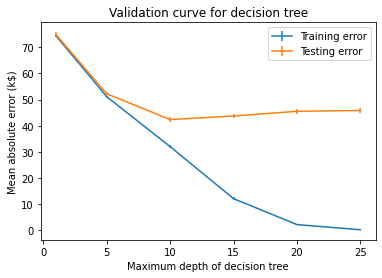

In [8]:
plt.errorbar(max_depth, train_errors.mean(axis=1),
             yerr=train_errors.std(axis=1), label='Training error')
plt.errorbar(max_depth, test_errors.mean(axis=1),
             yerr=test_errors.std(axis=1), label='Testing error')
plt.legend()

plt.xlabel("Maximum depth of decision tree")
plt.ylabel("Mean absolute error (k$)")
_ = plt.title("Validation curve for decision tree")

Tivemos sorte que a variância dos erros foi pequena em comparação com seus
respectivos valores e, portanto, as conclusões acima são bastante claras. Esta
nem sempre é necessariamente o caso.

## Resumo:

Neste caderno, vimos:

* como identificar se um modelo é generalizante, overfitting ou
  underfitting;
* como verificar a influência de um hiperparâmetro na compensação
  underfit / overfit.